In [143]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import itertools
from sklearn.model_selection import train_test_split
import cProfile
import pstats
from copy import copy
import math
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
from statsmodels.formula.api import ols
import scipy.stats as stats
from tukey_outliers_helper import TukeyOutliersHelper #outlier detection and removal based on IQR
from scipy.stats import pearsonr
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV

In [50]:
df=pd.read_csv('D:/DS STUFF/Datasets/winequality-red.csv')

In [ ]:
df.head()

In [ ]:
df.info()

In [53]:
df.isna().sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

In [54]:
df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


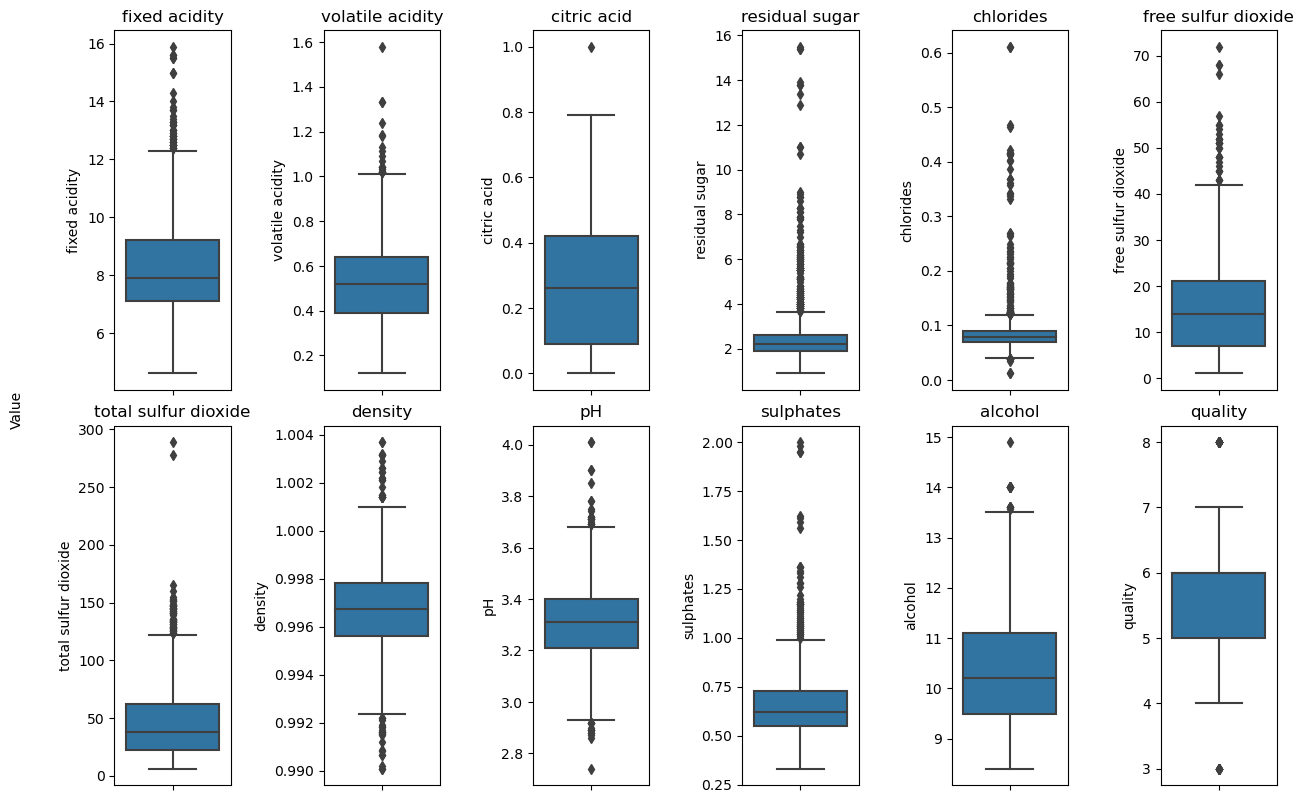

In [55]:
fig, axs = plt.subplots(2,6, figsize=(15,10), dpi=100)
fig.subplots_adjust(wspace=0.8, hspace=0.1)
axs=axs.flatten()
for i,col in enumerate(df.columns):
    sns.boxplot(y=col, data=df, ax=axs[i])
    axs[i].set_title(col)
    
fig.text(0.06, 0.5, 'Value', ha='center', va='center', rotation='vertical')

plt.show()

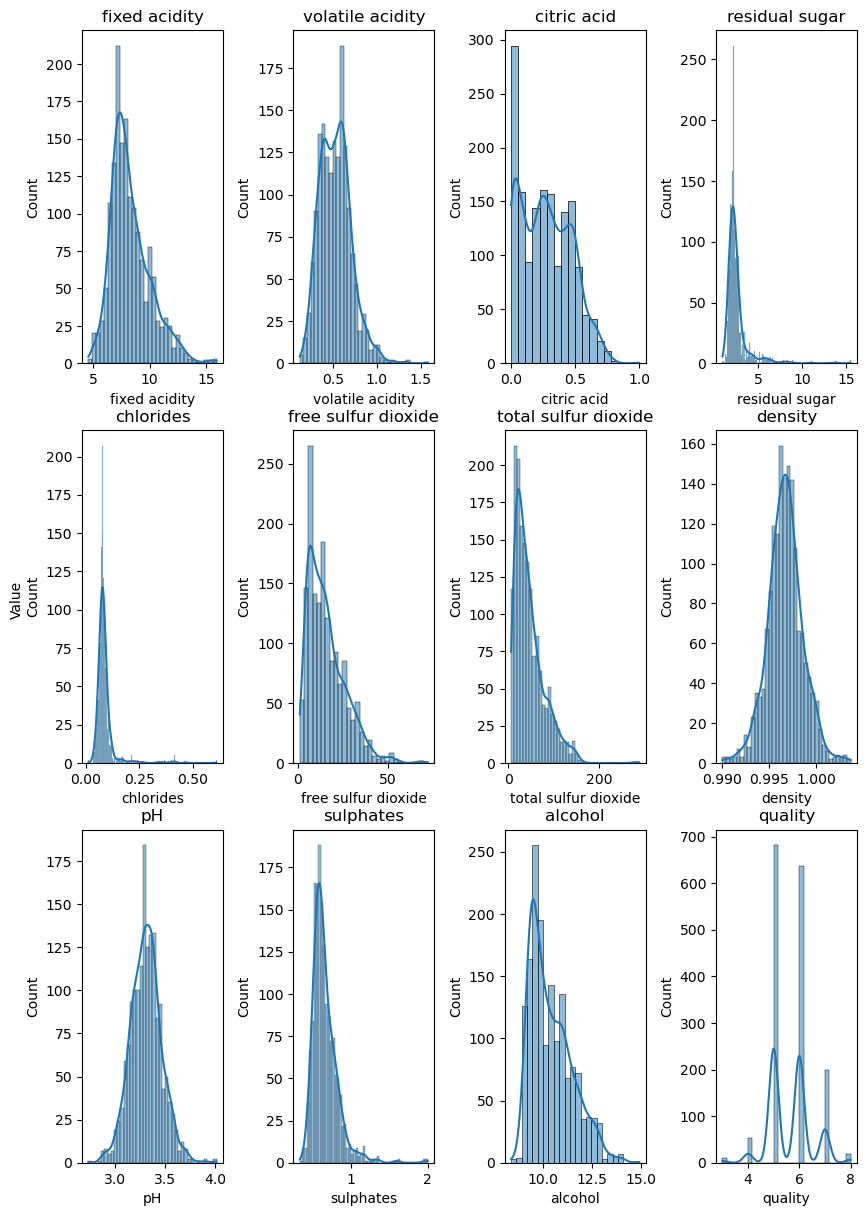

In [56]:
fig, axs = plt.subplots(3,4, figsize=(10,15), dpi=100)
fig.subplots_adjust(wspace=0.5, hspace=0.2)
axs=axs.flatten()
for i,col in enumerate(df.columns):
    sns.histplot(x=col, data=df, ax=axs[i],kde=True)
    axs[i].set_title(col)
    
fig.text(0.06, 0.5, 'Value', ha='center', va='center', rotation='vertical')

plt.show()

In [57]:
X_o=df.iloc[:,:-1]
y_o=df.iloc[:,-1]
print(f'Shape of X having predictors: {X_o.shape}, Shape of y having target: {y_o.shape}')

Shape of X having predictors: (1599, 11), Shape of y having target: (1599,)


As evident from distributions of predictors all exept quality and pH have signigicant skewness towards right so we transform these features by using log transformation to support are ML model.

In [58]:
X = X_o.copy()

In [59]:
predictors_to_transform = X.iloc[:,[0,1,2,3,4,5,6,9,10]]

In [60]:
for predictors in predictors_to_transform:
    if predictors == 'citric acid': #In the case of predictor 'Citric acid' we have 0 in our values so we use log(x+1) transformation.
        X[predictors] += 1
    X[predictors] = np.log(X[predictors])

In [61]:
X.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,2.001480,-0.356675,0.000000,0.641854,-2.577022,2.397895,3.526361,0.9978,3.51,-0.579818,2.240710
1,2.054124,-0.127833,0.000000,0.955511,-2.322788,3.218876,4.204693,0.9968,3.20,-0.385662,2.282382
2,2.054124,-0.274437,0.039221,0.832909,-2.385967,2.708050,3.988984,0.9970,3.26,-0.430783,2.282382
3,2.415914,-1.272966,0.444686,0.641854,-2.590267,2.833213,4.094345,0.9980,3.16,-0.544727,2.282382
4,2.001480,-0.356675,0.000000,0.641854,-2.577022,2.397895,3.526361,0.9978,3.51,-0.579818,2.240710


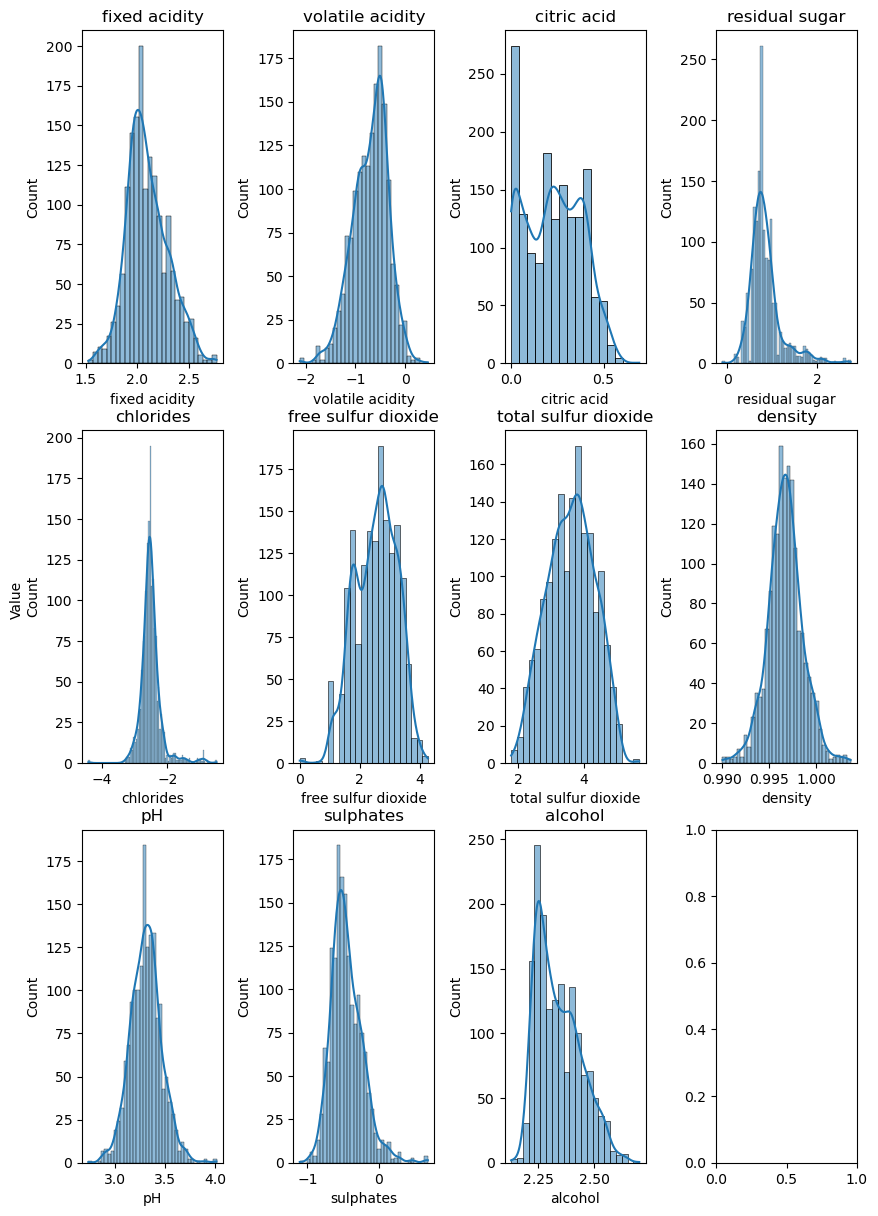

In [62]:
fig, axs = plt.subplots(3,4, figsize=(10,15), dpi=100)
fig.subplots_adjust(wspace=0.5, hspace=0.2)
axs=axs.flatten()
for i,col in enumerate(X.columns):
    sns.histplot(x=col, data=X, ax=axs[i],kde=True)
    axs[i].set_title(col)
    
fig.text(0.06, 0.5, 'Value', ha='center', va='center', rotation='vertical')

plt.show()

As evident from above distributions that the majority features have been normalized.

In [63]:
bounds = TukeyOutliersHelper().getBoundsFromDataFrame(X, kk=2.5, outlier_columns=X.columns)
bounds

fixed acidity              (1.312323034027958, 2.8669752340743067)
volatile acidity         (-2.1799121329335085, 0.7920164904466442)
citric acid              (-0.5750202421892399, 1.0118548100434617)
residual sugar          (-0.14229001096520943, 1.7396553421650405)
chlorides                 (-3.287546107635042, -1.779659537949608)
free sulfur dioxide       (-0.8006205726149613, 5.791053159393698)
total sulfur dioxide        (0.5008126241413771, 6.71736421426203)
density                            (0.9900125000000001, 1.0034225)
pH                                     (2.7350000000000003, 3.875)
sulphates                 (-1.305652640545421, 0.3931048949501002)
alcohol                   (1.8621585243270125, 2.7960783825977713)
dtype: object

In [64]:
fatal_inds_set = TukeyOutliersHelper.getOutlierDataPoints(X, bounds)

In [65]:
keep_inds = list(set(range(len(X))).difference(fatal_inds_set))
assert len(keep_inds) + len(fatal_inds_set) == len(X)

In [66]:
X_cleaned = X.iloc[keep_inds]
X_cleaned.shape

(1479, 11)

In [67]:
y_cleaned = y_o.iloc[keep_inds]
y_cleaned.shape

(1479,)

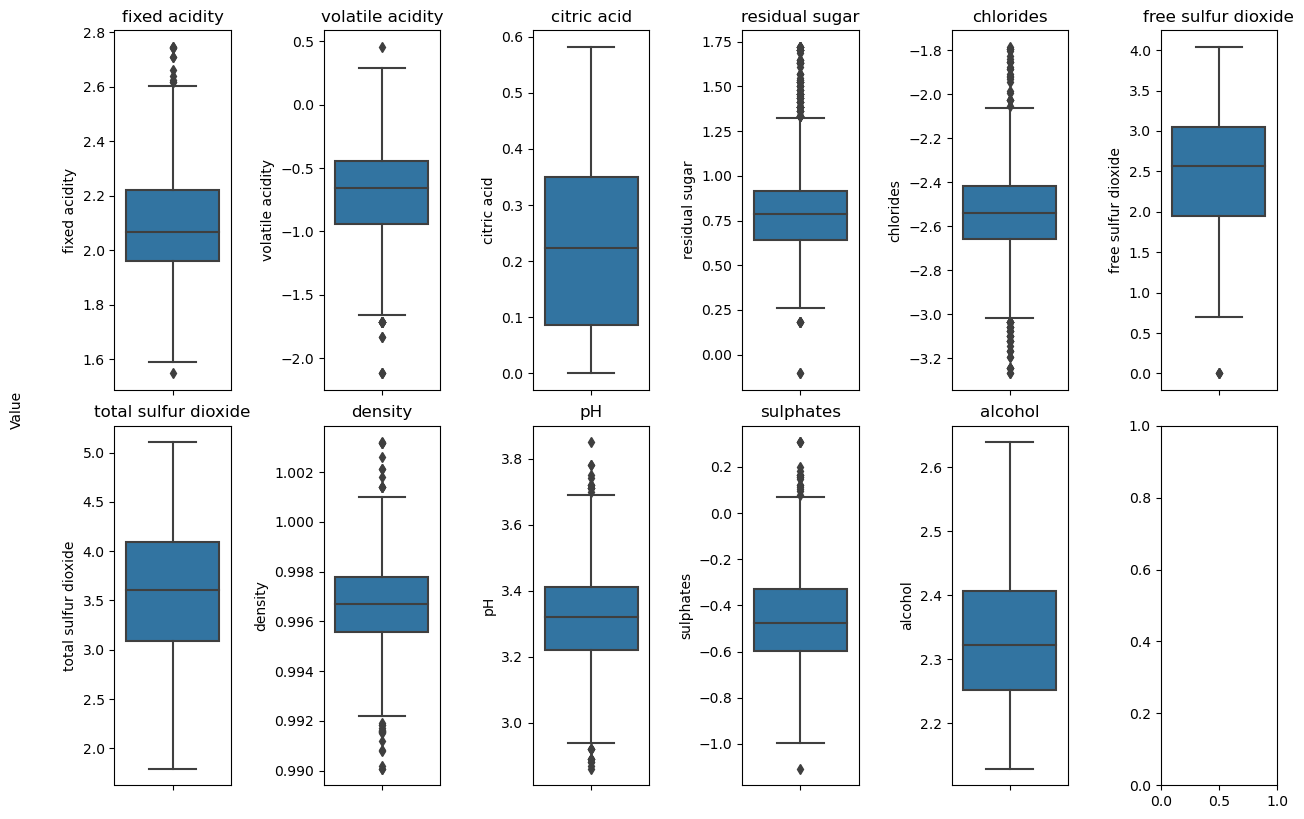

In [68]:
fig, axs = plt.subplots(2,6, figsize=(15,10), dpi=100)
fig.subplots_adjust(wspace=0.8, hspace=0.1)
axs=axs.flatten()
for i,col in enumerate(X_cleaned.columns):
    sns.boxplot(y=col, data=X_cleaned, ax=axs[i])
    axs[i].set_title(col)
    
fig.text(0.06, 0.5, 'Value', ha='center', va='center', rotation='vertical')

plt.show()

In [69]:
new_df=pd.concat([X_cleaned, y_cleaned], axis=1)
new_df #complete dataset with cleaned and transformed values
new_df.columns

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality'],
      dtype='object')

<AxesSubplot:>

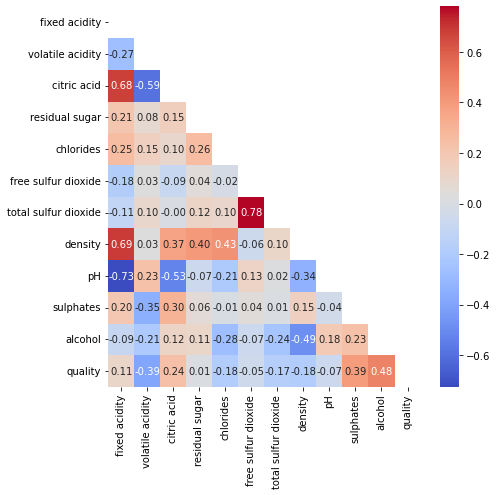

In [70]:
corr=new_df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
fig, ax = plt.subplots(figsize=(7, 7))
sns.heatmap(data=new_df.corr(), mask=mask, annot=True, fmt='.2f',cmap='coolwarm', ax=ax)
#Correlation matrix

In [71]:
corr_new_df = pd.DataFrame(columns=['absolute correlation coefficient', 'p_value'], index=new_df.columns)
for col1 in new_df.columns:
    for col2 in new_df.columns:
        # Calculate Pearson correlation coefficient and p-value
        corr, p = pearsonr(new_df[col1], new_df[col2])
        # Store absolute value of correlation coefficient and p-value in dataframe
        corr_new_df.loc[col1, 'absolute correlation coefficient'] = abs(corr)
        corr_new_df.loc[col1, 'p_value'] = p
        
corr_new_df = corr_new_df.astype(float)
corr_new_df = corr_new_df.sort_values(by='absolute correlation coefficient', ascending=False)


In [72]:
corr_new_df

,absolute correlation coefficient,p_value
quality,1.000000,0.000000e+00
alcohol,0.484643,5.826431e-88
sulphates,0.392419,1.223569e-55
volatile acidity,0.390643,4.134148e-55
citric acid,0.235577,4.245945e-20
chlorides,0.184983,7.501754e-13
density,0.184764,7.988600e-13
total sulfur dioxide,0.171488,3.164532e-11
fixed acidity,0.107971,3.168981e-05
pH,0.067825,9.075283e-03


Strong Correlation: Alcohal, sulphates, volatile acidity, citric acid

Note that pearson correlation is a first indication of whether a factor that plays a weaker or stronger role to predicting the quality of the wine. We should build our classifier to quantify it better



In [213]:
X_train, X_test, y_train, y_test = train_test_split(X_cleaned, y_cleaned,test_size=0.1, random_state=42)

In [166]:
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)
print(type(X_train),type(y_train))

X_train shape: (1331, 11)
X_test shape: (148, 11)
y_train shape: (1331,)
y_test shape: (148,)
<class 'pandas.core.frame.DataFrame'> <class 'pandas.core.series.Series'>


In [214]:
#Normalizing features before Gradeint descent is applied
scaler = StandardScaler()
X_train_norm=pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)

In [215]:
X_train_norm

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,0.381240,-1.726781,1.040633,-0.246633,0.862086,0.675263,-0.315916,-1.010493,-0.394316,-0.602851,0.878495
1,0.085872,-1.624191,1.130719,-0.246633,0.764231,-1.129503,-1.607295,-1.453424,-0.394316,-0.098161,1.842162
2,-0.227854,0.175787,-1.399213,-1.269745,-0.104026,-2.168537,-0.934768,-0.944053,-1.069083,-1.578241,-0.598953
3,-0.702639,-0.223794,-0.597523,0.835730,-0.164145,0.244025,0.040625,-0.257510,0.280452,-1.264968,0.312508
4,0.381240,0.280277,-1.205406,-0.071608,1.897988,0.140604,0.647150,-0.279656,-0.731699,-0.260749,0.504622
...,...,...,...,...,...,...,...,...,...,...,...
1326,-0.359013,-0.414039,0.220958,-0.246633,-0.225059,0.598373,0.887608,0.262934,0.550359,0.059266,-0.921483
1327,-0.100015,0.011417,0.715312,0.556909,0.185312,-0.090470,0.359264,0.993770,0.752789,-0.098161,0.312508
1328,1.076959,-0.414039,0.762776,0.556909,0.714512,0.029515,0.538693,0.905184,-0.664223,0.059266,-0.389373
1329,-0.920631,0.837007,-0.539695,-0.826603,1.859177,0.029515,-0.859700,-0.722587,0.685312,0.286413,0.878495


In [158]:
sgdr = SGDRegressor(max_iter=1000)
sgdr.fit(X_train_norm, y_train)
print(sgdr)
print(f"number of iterations completed: {sgdr.n_iter_}, number of weight updates: {sgdr.t_}")

SGDRegressor()
number of iterations completed: 9, number of weight updates: 11980.0


In [159]:
b = sgdr.intercept_
w = sgdr.coef_
print(f"model parameters: w: {w}, b:{b}")

model parameters: w: [ 0.08455941 -0.17484318 -0.03726702  0.02540543 -0.03815463  0.0502776
 -0.09846233 -0.0618336  -0.06269395  0.19357169  0.25022256], b:[5.63982471]


In [160]:
# make a prediction using sgdr.predict()
y_pred_sgd = sgdr.predict(X_train_norm)
# make a prediction using w,b. 
y_pred = np.dot(X_train_norm, w) + b  
print(f"prediction using np.dot() and sgdr.predict match: {(y_pred == y_pred_sgd).all()}")
print(f"Prediction on training set:\n{y_pred[:4]}" )
print(f"Target values \n{y_train[:4]}")
y_pred_sgd.size

prediction using np.dot() and sgdr.predict match: True
Prediction on training set:
[6.1514228  6.51151171 5.26671295 5.50924536]
Target values 
1215    6
947     7
1418    5
825     5
Name: quality, dtype: int64


1331

In [161]:
residual_train = y_train - y_pred_sgd
mse_train = (mean_squared_error(y_train, y_pred_sgd))
rmse_train = np.sqrt(mse_train)  # compute RMSE
print("MSE on training set:", mse_train)
print("RMSE on training set:", rmse_train)
print("R^2 on training set:", sgdr.score(X_train_norm, y_train))

MSE on training set: 0.387970540176238
RMSE on training set: 0.6228728121986365
R^2 on training set: 0.37240930736716893


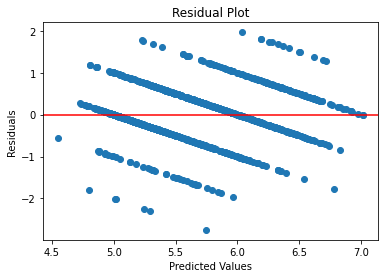

In [162]:
plt.scatter(y_pred_sgd, residual_train)
plt.title("Residual Plot")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.axhline(y=0, color='r', linestyle='-')
plt.show()

Using Lasso regularization to penalize the weights that do not contriubute to the accuracy of model and minimize them.

1331 1331


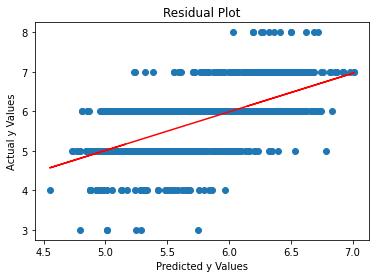

In [163]:
print(y_train.size,y_pred_sgd.size)
plt.scatter(y_pred_sgd,y_train)
m, b = np.polyfit(y_pred_sgd, y_train, 1)
plt.plot(y_pred_sgd, m*y_pred_sgd + b, color='red')
plt.title("Residual Plot")
plt.xlabel("Predicted y Values")
plt.ylabel("Actual y Values")
plt.show()

In [87]:
#Normalizing features before Gradeint descent is applied
scaler = StandardScaler()
X_test_norm=pd.DataFrame(scaler.fit_transform(X_test), columns=X_test.columns)
X_test_norm

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,-1.101163,1.600548,-1.360287,1.263776,-0.345447,1.155649,0.690271,-0.750521,1.990566,-1.200932,1.910735
1,1.190256,0.244184,1.103466,0.371452,-0.883938,-0.952627,-0.451107,1.773840,-1.219482,-0.298741,-1.112102
2,2.160827,-1.240802,2.124916,-0.090627,-0.282446,-0.952627,-0.249812,1.195340,-2.791750,1.300385,-0.604059
3,-0.601334,0.934244,-1.101327,-0.620554,-0.098563,0.422208,0.515834,0.222410,0.483809,-0.912260,-0.905681
4,-0.809228,-0.826760,0.325833,-0.815991,-0.606650,-1.520971,-1.996470,-1.907520,0.352787,-0.639784,1.986825
...,...,...,...,...,...,...,...,...,...,...,...
143,1.418520,-1.727830,0.964276,1.375006,-1.103713,0.734990,0.461576,0.406478,-1.153971,-0.728922,-0.804095
144,-0.026623,0.493806,-0.552402,-0.435145,2.018567,-1.924217,-2.177572,-0.992439,-0.564370,-0.381783,0.691383
145,0.092283,-1.152892,0.822176,0.070052,1.106297,-1.924217,-1.836726,-0.718967,-0.236814,-0.639784,1.600263
146,-0.402045,0.722773,-1.101327,0.223893,0.722704,-0.103003,0.080601,0.774613,0.811365,0.931254,-0.703562


In [88]:
# make a prediction using sgdr.predict()
y_pred_sgd = sgdr.predict(X_test_norm)
# make a prediction using w,b. 
y_pred = np.dot(X_test_norm, w) + b  
print(f"prediction using np.dot() and sgdr.predict match: {(y_pred == y_pred_sgd).all()}")
print(f"Prediction on test set:\n{y_pred[:4]}" )
print(f"Target values \n{y_train[:4]}")

prediction using np.dot() and sgdr.predict match: True
Prediction on test set:
[5.65424935 5.19257301 5.95032127 5.03624629]
Target values 
1215    6
947     7
1418    5
825     5
Name: quality, dtype: int64


In [89]:
residual_test = y_test - y_pred_sgd
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_sgd))  # compute RMSE
print("RMSE on test set:", rmse_test)
print("R^2 on test set:", sgdr.score(X_test_norm, y_test))

RMSE on test set: 0.6832836126314434
R^2 on test set: 0.41101982647889324


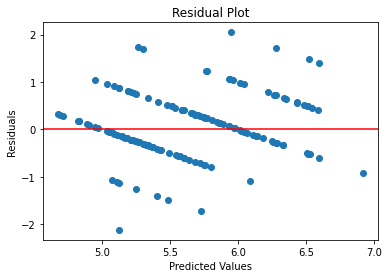

In [90]:
plt.scatter(y_pred_sgd, residual_test)
plt.title("Residual Plot")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.axhline(y=0, color='r', linestyle='-')
plt.show()

In [38]:
# X_train_norm_c=sm.add_constant(X_train_norm)
# X_train_norm_c

,const,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,1.0,0.381240,-1.726781,1.040633,-0.246633,0.862086,0.675263,-0.315916,-1.010493,-0.394316,-0.602851,0.878495
1,1.0,0.085872,-1.624191,1.130719,-0.246633,0.764231,-1.129503,-1.607295,-1.453424,-0.394316,-0.098161,1.842162
2,1.0,-0.227854,0.175787,-1.399213,-1.269745,-0.104026,-2.168537,-0.934768,-0.944053,-1.069083,-1.578241,-0.598953
3,1.0,-0.702639,-0.223794,-0.597523,0.835730,-0.164145,0.244025,0.040625,-0.257510,0.280452,-1.264968,0.312508
4,1.0,0.381240,0.280277,-1.205406,-0.071608,1.897988,0.140604,0.647150,-0.279656,-0.731699,-0.260749,0.504622
...,...,...,...,...,...,...,...,...,...,...,...,...
1326,1.0,-0.359013,-0.414039,0.220958,-0.246633,-0.225059,0.598373,0.887608,0.262934,0.550359,0.059266,-0.921483
1327,1.0,-0.100015,0.011417,0.715312,0.556909,0.185312,-0.090470,0.359264,0.993770,0.752789,-0.098161,0.312508
1328,1.0,1.076959,-0.414039,0.762776,0.556909,0.714512,0.029515,0.538693,0.905184,-0.664223,0.059266,-0.389373
1329,1.0,-0.920631,0.837007,-0.539695,-0.826603,1.859177,0.029515,-0.859700,-0.722587,0.685312,0.286413,0.878495


Performing crossvalidation test to find R^2 value for our model generated by SGDRegresssor

In [91]:
reg=SGDRegressor()
cv_results = cross_val_score(reg, X_test_norm, y_test, cv=5)
print(cv_results)

[0.35666416 0.33013827 0.45595618 0.14210479 0.15577538]


In [92]:
np.mean(cv_results)

0.2881277565223259

There is a clear evidence that our model does not significantly account for the variance present in dataset.

Performing LASSO regularization

In [226]:
sgdr_reg = SGDRegressor(penalty="l1", max_iter=1000)

# Set up the parameter grid for alpha values to test
param_grid = {'alpha': [0.1, 0.01, 0.001]}

# Create a GridSearchCV object
grid_search = GridSearchCV(sgdr_reg, param_grid, cv=10)

# Fit the GridSearchCV object to the training data
grid_search.fit(X_train_norm, y_train)

# Print the best parameter value(s) found
print("Best parameter(s): ", grid_search.best_params_)


Best parameter(s):  {'alpha': 0.001}


In [253]:
# Fit the model to the training data
sgdr_reg = SGDRegressor(penalty="l1", alpha=0.001, max_iter=10000)
sgdr_reg.fit(X_train_norm, y_train)
b_reg = sgdr_reg.intercept_
w_reg = sgdr_reg.coef_
print(f"model parameters: w_reg: {w_reg}, b:{b_reg}")
print(f"model parameters: w: {w}, b:{b}")

model parameters: w_reg: [ 0.09434894 -0.17378486 -0.04150484  0.02760669 -0.03026113  0.04098431
 -0.0838051  -0.0829755  -0.04482955  0.19839119  0.25012466], b:[5.62525534]
model parameters: w: [ 0.08455941 -0.17484318 -0.03726702  0.02540543 -0.03815463  0.0502776
 -0.09846233 -0.0618336  -0.06269395  0.19357169  0.25022256], b:0.12810903473421828


In [254]:
pred_y_sgdr_reg=sgdr_reg.predict(X_test_norm)

In [255]:
residual = y_test - pred_y_sgdr_reg
mse_test = (mean_squared_error(y_test, pred_y_sgdr_reg))
rmse_test = np.sqrt(mse_train)  # compute RMSE
print("MSE on test set:", mse_test)
print("RMSE on test set:", rmse_test)
print("R^2 on test set:", sgdr_reg.score(X_test_norm, y_test))

MSE on test set: 0.46690060205428824
RMSE on test set: 0.6228728121986365
R^2 on test set: 0.4109894149975736


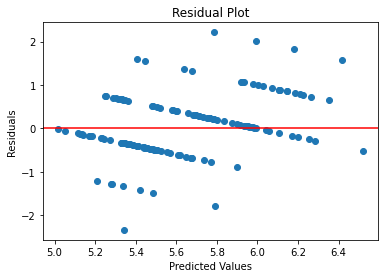

In [252]:
plt.scatter(pred_y_sgdr_reg, residual)
plt.title("Residual Plot")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.axhline(y=0, color='r', linestyle='-')
plt.show()

Peforming Lasso regularization shows a better R^2 value which makes this model a better fit than before however it is still not good enough to be considered as a good fit.